# PySpark implementation of LLE

### Based on 

* https://blog.paperspace.com/dimension-reduction-with-lle/
* https://github.com/asdspal/dimRed/blob/master/LLE.ipynb

In [15]:
pwd

u'/home/ec2-user/Projects/ScalableML/PySparkDemos'

In [16]:
sc

<SparkContext master=spark://ec2-18-224-45-143.us-east-2.compute.amazonaws.com:7077 appName=PySparkShell>

In [17]:
%matplotlib inline

In [18]:
#necessary imports

from sklearn import datasets
from pyspark.sql import SQLContext as SQC
from pyspark.mllib.linalg import Vectors as mllibVs, VectorUDT as mllibVUDT
from pyspark.ml.linalg import Vectors as mlVs, VectorUDT as mlVUDT
from pyspark.sql.types import *
from pyspark.mllib.linalg import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.linalg.distributed import IndexedRowMatrix
import math as m
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg

In [19]:
#iris_tuple = datasets.load_iris()
#iris = iris_tuple.data
#iris.shape

#df = (sqlContext.createDataFrame(sc.parallelize(iris.tolist()).zipWithIndex().
#                                 map(lambda x: (x[1], mlVs.dense(x[0]))), ["id", "features"]))
#df.show()

In [20]:
#iris[0:3,:]

In [21]:
n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
X[0:3,:]

array([[ 0.44399868,  1.18576054, -0.10397256],
       [ 0.89724097,  0.02012739, -1.44154121],
       [ 0.8240493 ,  0.95165239, -0.43348191]])

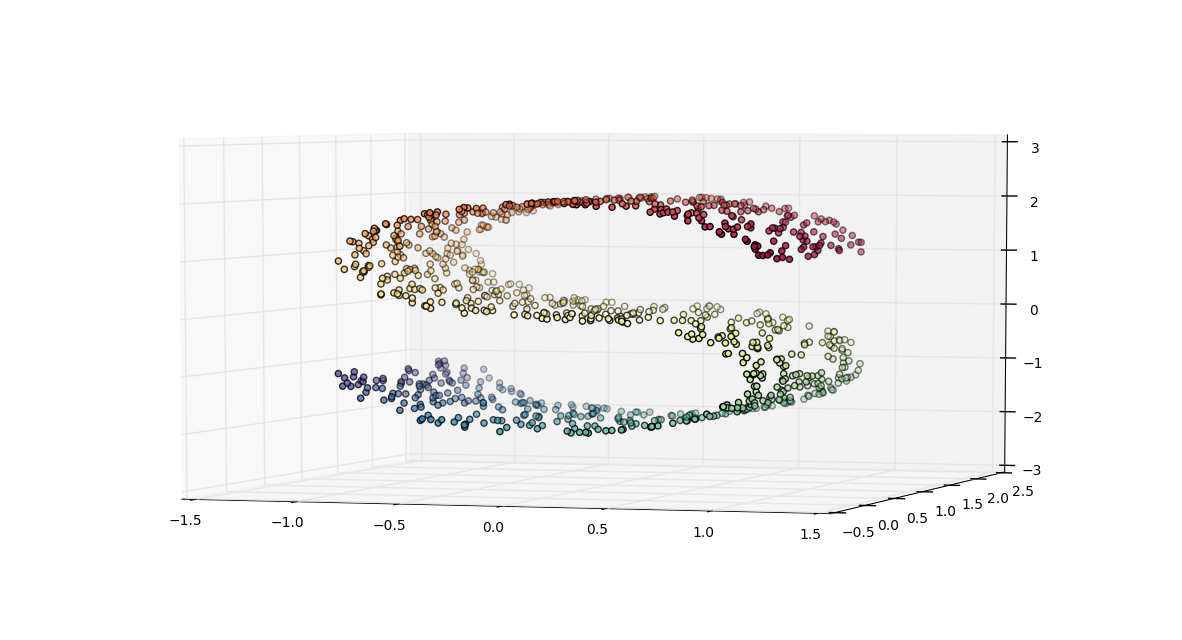

In [22]:
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

In [23]:
sqlContext = SQC(sc)
df = (sqlContext.createDataFrame(sc.parallelize(X.tolist()).zipWithIndex().
                              map(lambda x: (x[1], mlVs.dense(x[0]))), ["id", "features"]))    

In [24]:
df.head()

Row(id=0, features=DenseVector([0.444, 1.1858, -0.104]))

In [25]:
df.count()

1000

In [26]:
udf_dist = udf(lambda x, y:  float(x.squared_distance(y)), DoubleType())


df_2 = df
    
df = df.crossJoin(df ).toDF('x_id', 'x_feature', 'y_id', 'y_feature')
df = df.withColumn("sim", udf_dist(df.x_feature, df.y_feature))

df = df.drop("x_feature")

st = struct([name for name in ["y_id", "sim","y_feature"]]).alias("map")
df = df.select("x_id", st)
df  = df.groupby("x_id").agg(collect_list("map").alias("map"))
df = df.join(df_2, df_2.id == df.x_id, "inner").drop("x_id")



In [27]:
#df.head()

In [28]:
df.cache()
df.show()

+--------------------+---+--------------------+
|                 map| id|            features|
+--------------------+---+--------------------+
|[[125, 7.36476444...| 26|[0.21795970396658...|
|[[125, 6.05239109...| 29|[-0.7203399249526...|
|[[0, 4.0025864950...|474|[-0.8453852174078...|
|[[0, 3.5340713630...|964|[-0.9946310116549...|
|[[0, 3.5707672729...| 65|[-0.9448826896651...|
|[[500, 1.69626130...|191|[-0.3957959463773...|
|[[250, 4.69128712...|418|[0.46389110026949...|
|[[125, 0.49703262...|541|[0.98321096466143...|
|[[125, 0.04981651...|558|[0.91760985802714...|
|[[0, 4.9853103412...|222|[-0.8453802441127...|
|[[0, 3.3514789134...|270|[-0.9775902956951...|
|[[0, 4.9404123072...|293|[-0.2167441420575...|
|[[0, 1.1330555170...|730|[0.01002000022520...|
|[[0, 3.3779316621...|938|[-0.9995824479214...|
|[[500, 2.56851257...|243|[0.32033561347057...|
|[[250, 5.81062285...|278|[0.94230243189942...|
|[[250, 1.20518184...|367|[-0.8143822539597...|
|[[250, 6.61835220...|442|[-0.7602033998

In [29]:
# calculate local neighborhood matrix

def get_weights(map_list, k, features, reg):
    

    sorted_map = sorted(map_list, key = lambda x: x[1])[1:(k+1)]
    
    neighbors = np.array([s[2] for s in sorted_map])
    ind = [s[0] for s in sorted_map]
    
    nbors, n_features = neighbors.shape
    
    neighbors_mat = neighbors - features.toArray().reshape(1,n_features)
    
    cov_neighbors = np.dot(neighbors_mat, neighbors_mat.T)
    
    # add regularization term
    trace = np.trace(cov_neighbors)
    if trace > 0:
        R = reg * trace
    else:
        R = reg
    
    cov_neighbors.flat[::nbors + 1] += R
    
    weights = linalg.solve(cov_neighbors, np.ones(k).T, sym_pos=True)
    weights = weights/weights.sum()
    
    full_weights = np.zeros(len(map_list))
    full_weights[ind] = weights
    
    return(Vectors.dense(full_weights))


In [30]:
udf_sort = udf(get_weights, mllibVUDT())

df = df.withColumn("weights", udf_sort("map", lit(10), "features", lit(0.001)))


In [31]:
#df.head()

In [32]:
df.show()

+--------------------+---+--------------------+--------------------+
|                 map| id|            features|             weights|
+--------------------+---+--------------------+--------------------+
|[[125, 7.36476444...| 26|[0.21795970396658...|[0.0,0.0,0.0,0.0,...|
|[[125, 6.05239109...| 29|[-0.7203399249526...|[0.0,0.0,0.0,0.0,...|
|[[0, 4.0025864950...|474|[-0.8453852174078...|[0.0,0.0,0.0,0.0,...|
|[[0, 3.5340713630...|964|[-0.9946310116549...|[0.0,0.0,0.0,0.0,...|
|[[0, 3.5707672729...| 65|[-0.9448826896651...|[0.0,0.0,0.0,0.0,...|
|[[500, 1.69626130...|191|[-0.3957959463773...|[0.0,0.0,0.0,0.0,...|
|[[250, 4.69128712...|418|[0.46389110026949...|[0.0,0.0,0.0,0.0,...|
|[[125, 0.49703262...|541|[0.98321096466143...|[0.0,0.0,0.0,0.0,...|
|[[125, 0.04981651...|558|[0.91760985802714...|[0.0,0.0,0.0,0.0,...|
|[[0, 4.9853103412...|222|[-0.8453802441127...|[0.0,0.0,0.0,0.0,...|
|[[0, 3.3514789134...|270|[-0.9775902956951...|[0.0,0.0,0.0,0.0,...|
|[[0, 4.9404123072...|293|[-0.2167

In [33]:
# udf for creating a row of identity matrix 
def I(ind):
    i = [0]*n_points
    i[ind]=1.0
    return(mllibVs.dense(i))


In [38]:
# convert dataframe to indexedrowmatrix
weights_irm = IndexedRowMatrix(df.select(["id","weights"]).rdd.map(lambda x:(x[0],  I(x[0])-x[1])))


In [40]:
M = weights_irm.toBlockMatrix().transpose().multiply( weights_irm.toBlockMatrix() )

In [41]:
M.cache()

In [42]:
d=2

In [43]:

SVD = M.toIndexedRowMatrix().computeSVD(n_points, True)

# select the vectors for low dimensional embedding
lle_embedding = np.fliplr(SVD.V.toArray()[:,-(d+1):-1])

In [44]:
lle_embedding.shape

(1000, 2)

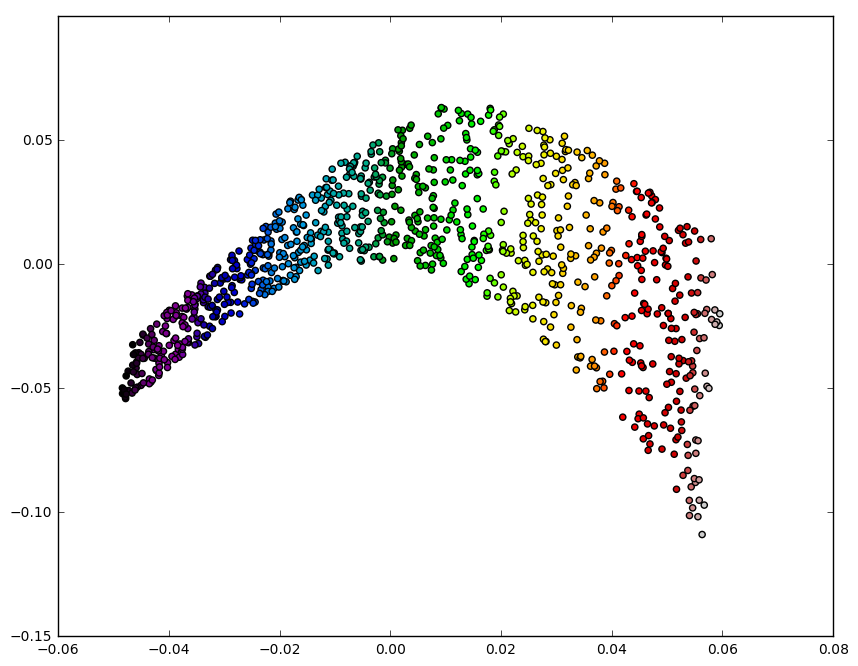

In [45]:
fig = plt.figure(figsize=(10,8))
plt.scatter(lle_embedding[:,0],lle_embedding[:,1],c=color, cmap=plt.cm.spectral)